# Load dữ liệu train và validation

Đang tải toàn bộ dữ liệu từ thư mục: cropped_and_augment
Found 43118 files belonging to 52 classes.
Các lớp tìm thấy: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '6', '7', '8', '9']
Tổng số lớp: 52

--- Thông tin các tập dữ liệu đã chia ---
Số ảnh trong Train: 25870
Số ảnh trong Validation: 8623
Số ảnh trong Test: 8625


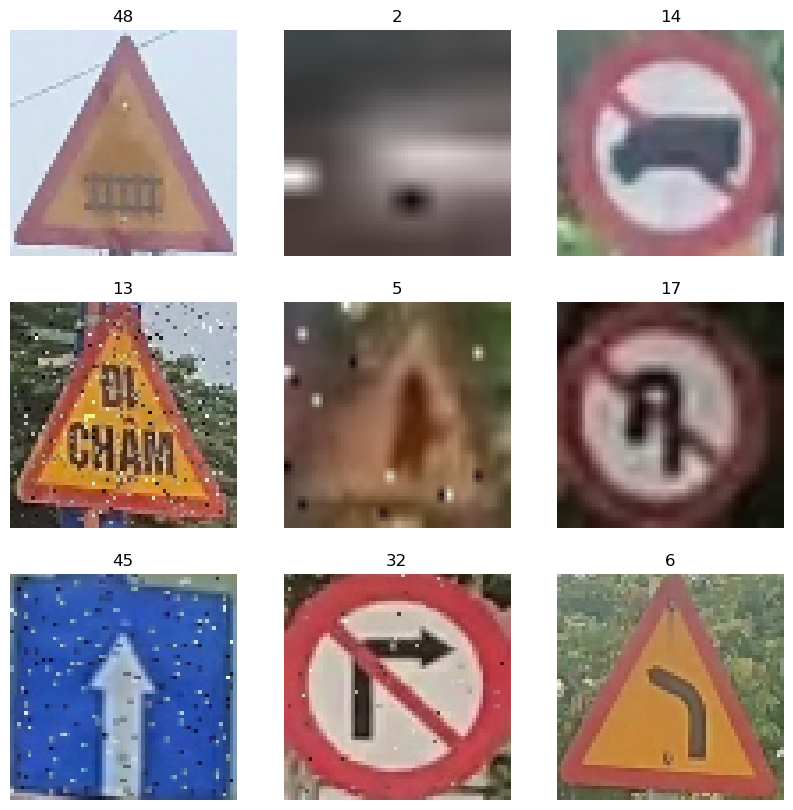

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

# --- Cấu hình ---
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
DATA_DIR = "cropped_and_augment"
EPOCHS = 10
SEED = 123

print("Đang tải toàn bộ dữ liệu từ thư mục:", DATA_DIR)

# --- Tải toàn bộ dữ liệu một lần ---
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE  # batch ở đây chỉ để load nhanh hơn
)

class_names = full_ds.class_names
num_classes = len(class_names)
print(f"Các lớp tìm thấy: {class_names}")
print(f"Tổng số lớp: {num_classes}")

# --- Ghép toàn bộ ảnh và nhãn ---
image_list = []
label_list = []

for images, labels in full_ds:
    image_list.append(images)
    label_list.append(labels)

all_images = tf.concat(image_list, axis=0)
all_labels = tf.concat(label_list, axis=0)

# --- Shuffle toàn bộ dữ liệu ---
num_samples = all_images.shape[0]
indices = tf.random.shuffle(tf.range(num_samples), seed=SEED)
all_images = tf.gather(all_images, indices)
all_labels = tf.gather(all_labels, indices)

# --- Chia theo tỷ lệ 60-20-20 ---
train_size = int(0.6 * num_samples)
val_size = int(0.2 * num_samples)
test_size = num_samples - train_size - val_size

train_images, train_labels = all_images[:train_size], all_labels[:train_size]
val_images, val_labels = all_images[train_size:train_size+val_size], all_labels[train_size:train_size+val_size]
test_images, test_labels = all_images[train_size+val_size:], all_labels[train_size+val_size:]

# --- Tạo tf.data.Dataset ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# --- Thông tin kiểm tra ---
print("\n--- Thông tin các tập dữ liệu đã chia ---")
print(f"Số ảnh trong Train: {train_size}")
print(f"Số ảnh trong Validation: {val_size}")
print(f"Số ảnh trong Test: {test_size}")



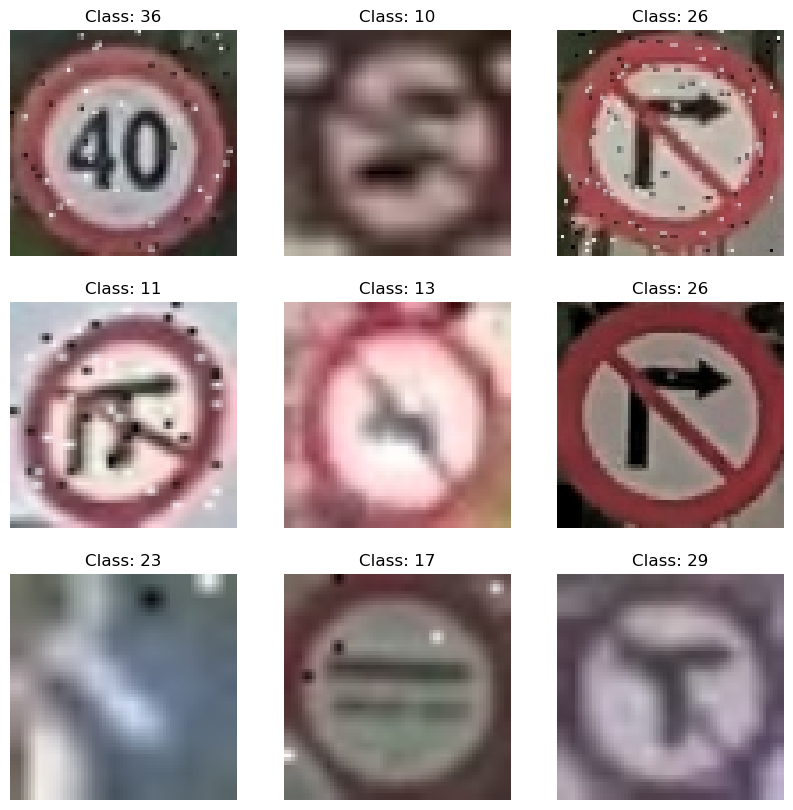

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()

        # Nếu ảnh nằm trong [0,1] thì chuyển về [0,255]
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        else:
            img = img.astype("uint8")

        plt.imshow(img)
        plt.title(class_names[labels[i].numpy()])  # Đã sửa
        plt.axis("off")
    plt.show()


# Mô hình

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),

    tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

#compile mô hình
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
    metrics=['accuracy']
)
model.summary()

c:\Users\84335\anaconda3\envs\tf_traffic_sign\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,291,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 52)             │        13,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,552,116 (24.99 MB)

 Trainable params: 6,551,476 (24.99 MB)

 Non-trainable params: 640 (2.50 KB)

# Huấn luyện

In [11]:
from sklearn.utils import class_weight
import numpy as np

EPOCHS = 10

# --- B1: Thu thập nhãn từ train_ds ---
y_train = []
for batch_images, batch_labels in train_ds:
    y_train.extend(batch_labels.numpy())

y_train = np.array(y_train)

# --- B2: Tính class_weight ---
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# In ra để kiểm tra
print("Class weights:", class_weights)

# --- B3: Huấn luyện mô hình ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)
model.evaluate(test_ds)

Class weights: {0: 1.060767590618337, 1: 1.3373655913978495, 2: 0.756079027355623, 3: 1.1817102137767221, 4: 0.9930139720558883, 5: 1.1255656108597285, 6: 0.8291666666666667, 7: 1.0386221294363256, 8: 0.7810047095761381, 9: 0.8011272141706924, 10: 0.8947841726618705, 11: 1.063034188034188, 12: 1.3667582417582418, 13: 0.8037156704361874, 14: 2.794943820224719, 15: 0.8667247386759582, 16: 1.2855297157622738, 17: 0.8277870216306157, 18: 1.2691326530612246, 19: 0.8169129720853858, 20: 0.8037156704361874, 21: 1.040794979079498, 22: 0.7985553772070626, 23: 1.2756410256410255, 24: 0.8562822719449226, 25: 0.7934609250398724, 26: 0.9111721611721612, 27: 1.5260736196319018, 28: 0.7896825396825397, 29: 0.820957095709571, 30: 0.756079027355623, 31: 0.7972756410256411, 32: 0.916206261510129, 33: 1.2626903553299493, 34: 0.8789752650176679, 35: 0.9422348484848485, 36: 1.0585106382978724, 37: 1.4420289855072463, 38: 1.0862445414847162, 39: 8.883928571428571, 40: 0.9111721611721612, 41: 1.2406483790523

[0.4450702965259552, 0.9536231756210327]

135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.9585 - loss: 0.3628
[0.4450702965259552, 0.9536231756210327]


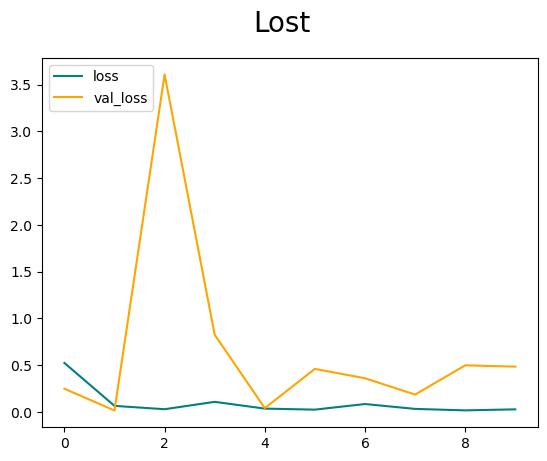

In [13]:
#Đồ thị loss của train và loss của val
print(model.evaluate(test_ds))
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Lost', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Dự đoán trên validation
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds_classes = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes.numpy())

# Ép kiểu numpy cho an toàn
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Lấy các class thực sự xuất hiện
used_labels = sorted(set(y_true) | set(y_pred))
used_class_names = [class_names[i] for i in used_labels]

# In báo cáo phân loại
print(classification_report(
    y_true,
    y_pred,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
))



              precision    recall  f1-score   support

           0       0.91      0.93      0.92       151
           1       0.99      0.98      0.98       125
          10       0.97      0.99      0.98       211
          11       0.98      1.00      0.99       134
          12       0.99      1.00      1.00       166
          13       0.79      1.00      0.88       150
          14       0.95      0.95      0.95       220
          15       0.99      0.95      0.97       153
          16       0.97      0.97      0.97       203
          17       1.00      0.92      0.96       180
          18       0.99      0.95      0.97       172
          19       0.95      1.00      0.97       163
           2       0.77      0.92      0.84       129
          20       0.87      0.98      0.92       225
          21       0.98      1.00      0.99        57
          22       0.92      0.85      0.88       202
          23       0.85      1.00      0.92       141
          24       1.00    

# Lưu mô hình

In [15]:
model.save("traffic_sign_classifier.h5")